# Comprehensive ML Model Optimization Techniques - Step by Step Learning Guide

This notebook demonstrates various optimization techniques applied **sequentially** to a baseline model. We'll compare the impact of each technique on:
- **Model Accuracy**
- **Model Size**
- **Inference Time**

## Optimization Techniques Covered:

1. **Feature Selection & Dimensionality Reduction** - Remove redundant features
2. **Hyperparameter Tuning** - Find optimal model parameters
3. **Model Pruning** - Remove unnecessary model weights
4. **Model Quantization** - Reduce precision for faster inference
5. **Ensemble Methods** - Combine multiple models
6. **Hardware Acceleration** - Use GPU for faster processing

---

## Learning Objectives:
- Build a strong baseline model
- Apply each optimization technique independently
- Measure and compare impact on accuracy, size, and speed
- Understand trade-offs between different optimization strategies

## Step 1: Setup and Installation

First, install and import all required libraries.

In [5]:
# Install required packages (run this if you get import errors)
# !pip install tensorflow tensorflow-model-optimization keras-tuner scikit-learn pandas numpy matplotlib seaborn
# Note: If using pip directly in terminal, use: python -m pip install <package_name>

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import os
import tempfile
import zipfile
from datetime import datetime

# Import keras directly for compatibility with keras-tuner
import keras
from keras import layers, models

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Keras Tuner version: {kt.__version__}")
print(f"TensorFlow Model Optimization version: {tfmot.__version__}")
print(f"Setup complete!")



TensorFlow version: 2.20.0
Keras version: 3.12.0
Keras Tuner version: 1.4.8
TensorFlow Model Optimization version: 0.8.0
Setup complete!
TensorFlow version: 2.20.0
Keras version: 3.12.0
Keras Tuner version: 1.4.8
TensorFlow Model Optimization version: 0.8.0
Setup complete!


## Step 2: Load and Prepare Data

We'll use the MNIST dataset (handwritten digits 0-9) for this demonstration.

In [6]:
# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape for feature engineering (flatten for PCA/feature selection)
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

print(f"Training data shape: {train_images.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Training data (flat) shape: {train_images_flat.shape}")
print(f"Number of features: {train_images_flat.shape[1]}")
print(f"Number of classes: {len(np.unique(train_labels))}")

Loading MNIST dataset...
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Training data (flat) shape: (60000, 784)
Number of features: 784
Number of classes: 10
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Training data (flat) shape: (60000, 784)
Number of features: 784
Number of classes: 10


## Step 3: Train Baseline Model

Let's train a decent baseline model that we'll optimize step by step.

In [7]:
def create_baseline_model(input_shape=(28, 28)):
    """
    Create a baseline CNN model with moderate complexity.
    This serves as our reference point for all optimizations.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((28, 28, 1), input_shape=input_shape),
        
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train baseline model
print("Creating baseline model...")
baseline_model = create_baseline_model()
baseline_model.summary()

print("\nTraining baseline model...")
start_time = time.time()
baseline_history = baseline_model.fit(
    train_images, 
    train_labels,
    epochs=10,
    validation_split=0.2,
    batch_size=128,
    verbose=1
)
baseline_training_time = time.time() - start_time

# Evaluate baseline model
print("\nEvaluating baseline model...")
start_time = time.time()
baseline_loss, baseline_accuracy = baseline_model.evaluate(test_images, test_labels, verbose=0)
baseline_inference_time = (time.time() - start_time) / len(test_images)

# Save baseline model
baseline_model.save('baseline_model.keras')

print(f"\n{'='*60}")
print(f"BASELINE MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Training Time: {baseline_training_time:.2f} seconds")
print(f"Test Accuracy: {baseline_accuracy:.4f}")
print(f"Test Loss: {baseline_loss:.4f}")
print(f"Average Inference Time per Sample: {baseline_inference_time*1000:.4f} ms")
print(f"{'='*60}\n")

Creating baseline model...


c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\reshaping\reshape.py:38: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Training baseline model...
Epoch 1/10
Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8701 - loss: 0.4086 - val_accuracy: 0.9745 - val_loss: 0.0860
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8701 - loss: 0.4086 - val_accuracy: 0.9745 - val_loss: 0.0860
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9578 - loss: 0.1369 - val_accuracy: 0.9827 - val_loss: 0.0588
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9578 - loss: 0.1369 - val_accuracy: 0.9827 - val_loss: 0.0588
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9680 - loss: 0.1073 - val_accuracy: 0.9856 - val_loss: 0.0490
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9680 - loss: 0.1073 - val_accuracy: 0.9856 - val_loss: 0.0490
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9731 - loss: 0.0859 - val_accuracy: 0.9871 - val_loss: 0.0436
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - acc

## Results Tracking

Let's create a results tracking system to compare all optimization techniques.

In [8]:
# Initialize results tracking
results = {
    'Technique': ['Baseline'],
    'Accuracy': [baseline_accuracy],
    'Model Size (KB)': [os.path.getsize('baseline_model.keras') / 1024],
    'Inference Time (ms)': [baseline_inference_time * 1000],
    'Training Time (s)': [baseline_training_time],
    'Notes': ['Original model without optimization']
}

def add_result(technique, accuracy, model_path, inference_time, training_time, notes):
    """Helper function to track results"""
    results['Technique'].append(technique)
    results['Accuracy'].append(accuracy)
    results['Model Size (KB)'].append(os.path.getsize(model_path) / 1024 if os.path.exists(model_path) else 0)
    results['Inference Time (ms)'].append(inference_time * 1000)
    results['Training Time (s)'].append(training_time)
    results['Notes'].append(notes)

def print_results_table():
    """Print formatted results table"""
    df = pd.DataFrame(results)
    print("\n" + "="*100)
    print("OPTIMIZATION RESULTS COMPARISON")
    print("="*100)
    print(df.to_string(index=False))
    print("="*100 + "\n")

print("Results tracking initialized!")

Results tracking initialized!


## Optimization Technique 1: Feature Selection & Dimensionality Reduction

**Goal**: Reduce the number of input features using PCA to simplify the model and speed up training.

**Method**: Use Principal Component Analysis (PCA) to reduce 784 features (28x28 pixels) to the most important components.

In [9]:
print("="*60)
print("TECHNIQUE 1: FEATURE SELECTION & DIMENSIONALITY REDUCTION")
print("="*60)

# Apply PCA to reduce dimensionality
n_components = 200  # Reduce from 784 to 200 features
print(f"\nApplying PCA: {train_images_flat.shape[1]} → {n_components} features")

pca = PCA(n_components=n_components, random_state=42)
train_images_pca = pca.fit_transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Reduced feature shape: {train_images_pca.shape}")

# Create a simpler model for PCA-reduced features
def create_pca_model(input_dim):
    """Model for PCA-reduced features"""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train model with PCA features
print("\nTraining model with PCA-reduced features...")
pca_model = create_pca_model(n_components)
start_time = time.time()
pca_history = pca_model.fit(
    train_images_pca,
    train_labels,
    epochs=10,
    validation_split=0.2,
    batch_size=128,
    verbose=1
)
pca_training_time = time.time() - start_time

# Evaluate PCA model
start_time = time.time()
pca_loss, pca_accuracy = pca_model.evaluate(test_images_pca, test_labels, verbose=0)
pca_inference_time = (time.time() - start_time) / len(test_images_pca)

# Save PCA model
pca_model.save('pca_optimized_model.keras')

# Add results
add_result(
    technique='1. PCA (200 components)',
    accuracy=pca_accuracy,
    model_path='pca_optimized_model.keras',
    inference_time=pca_inference_time,
    training_time=pca_training_time,
    notes=f'Reduced features from 784 to {n_components}'
)

print(f"\n✓ PCA Model - Accuracy: {pca_accuracy:.4f} | Time: {pca_inference_time*1000:.4f} ms")
print_results_table()

TECHNIQUE 1: FEATURE SELECTION & DIMENSIONALITY REDUCTION

Applying PCA: 784 → 200 features
Explained variance ratio: 0.9664
Reduced feature shape: (60000, 200)

Training model with PCA-reduced features...
Epoch 1/10
Explained variance ratio: 0.9664
Reduced feature shape: (60000, 200)

Training model with PCA-reduced features...
Epoch 1/10


c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8514 - loss: 0.5004 - val_accuracy: 0.9484 - val_loss: 0.1770
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8514 - loss: 0.5004 - val_accuracy: 0.9484 - val_loss: 0.1770
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9376 - loss: 0.2085 - val_accuracy: 0.9623 - val_loss: 0.1301
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9376 - loss: 0.2085 - val_accuracy: 0.9623 - val_loss: 0.1301
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9538 - loss: 0.1522 - val_accuracy: 0.9696 - val_loss: 0.1052
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9538 - loss: 0.1522 - val_accuracy: 0.9696 - val_loss: 0.1052
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9630 - loss: 0.1225 - val_accuracy: 0.9729 - val_loss: 0.0968
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9630 - loss: 0.1225 - val_accuracy: 0.9729 - val_

## Optimization Technique 2: Hyperparameter Tuning

**Goal**: Find the optimal hyperparameters for our baseline model architecture.

**Method**: Use Keras Tuner (Hyperband algorithm) to search for the best learning rate and number of units.

In [10]:
print("="*60)
print("TECHNIQUE 2: HYPERPARAMETER TUNING")
print("="*60)

# ⚠️ PERFORMANCE NOTE: This technique can be resource-intensive!
# Adjust settings below based on your machine's capabilities:
# - FAST_MODE: Quick demo (2-3 minutes) - fewer options, fewer epochs
# - STANDARD_MODE: Balanced (5-10 minutes) - moderate search space
# - FULL_MODE: Comprehensive (15-30 minutes) - full hyperparameter search
# For high-spec machines with GPU, use FULL_MODE for best results

TUNING_MODE = "FAST_MODE"  # Change to "STANDARD_MODE" or "FULL_MODE" for better results

# Configuration based on mode
if TUNING_MODE == "FAST_MODE":
    print("⚡ Using FAST_MODE: Optimized for quick demonstration")
    conv1_options = [32]  # Fixed value
    conv2_options = [64]  # Fixed value
    dense_options = [64, 128]  # Reduced options
    lr_options = [1e-3]  # Fixed value
    max_epochs_search = 3  # Reduced epochs for search
    max_epochs_final = 5  # Reduced final training
    early_stop_patience = 2
    factor = 2
elif TUNING_MODE == "STANDARD_MODE":
    print("⚙️ Using STANDARD_MODE: Balanced performance and time")
    conv1_options = [32, 64]
    conv2_options = [64, 128]
    dense_options = [64, 128]
    lr_options = [1e-2, 1e-3]
    max_epochs_search = 5
    max_epochs_final = 8
    early_stop_patience = 2
    factor = 3
else:  # FULL_MODE
    print("🚀 Using FULL_MODE: Comprehensive search (requires high-spec machine)")
    conv1_options = [16, 32, 64]
    conv2_options = [32, 64, 128]
    dense_options = [64, 128, 256]
    lr_options = [1e-2, 1e-3, 1e-4]
    max_epochs_search = 10
    max_epochs_final = 10
    early_stop_patience = 3
    factor = 3

print(f"Search space: {len(conv1_options)} × {len(conv2_options)} × {len(dense_options)} × {len(lr_options)} = "
      f"{len(conv1_options) * len(conv2_options) * len(dense_options) * len(lr_options)} combinations")

def build_tuned_model(hp):
    """Model with tunable hyperparameters"""
    model = keras.Sequential([
        layers.Reshape((28, 28, 1), input_shape=(28, 28)),
        
        # Tune number of filters in Conv layers
        layers.Conv2D(
            hp.Choice('conv1_filters', values=conv1_options),
            (3, 3),
            activation='relu'
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(
            hp.Choice('conv2_filters', values=conv2_options),
            (3, 3),
            activation='relu'
        ),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        
        # Tune number of units in Dense layer
        layers.Dense(
            hp.Choice('dense_units', values=dense_options),
            activation='relu'
        ),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=lr_options)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Setup tuner with optimized settings
print("\nSetting up Keras Tuner (Hyperband algorithm)...")
tuner = kt.Hyperband(
    build_tuned_model,
    objective='val_accuracy',
    max_epochs=max_epochs_search,
    factor=factor,
    directory='hyperband_dir',
    project_name='mnist_optimization',
    overwrite=True  # Start fresh each time
)

# Run hyperparameter search
print(f"\nSearching for best hyperparameters...")
print(f"Expected time: {TUNING_MODE.replace('_', ' ').title()}")
start_time = time.time()
tuner.search(
    train_images[:10000] if TUNING_MODE == "FAST_MODE" else train_images,  # Use subset for FAST_MODE
    train_labels[:10000] if TUNING_MODE == "FAST_MODE" else train_labels,
    epochs=max_epochs_search,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience)],
    batch_size=256 if TUNING_MODE == "FAST_MODE" else 128,  # Larger batch for speed
    verbose=1 if TUNING_MODE == "FAST_MODE" else 0
)
tuning_time = time.time() - start_time
print(f"\n⏱️ Search completed in {tuning_time:.2f} seconds ({tuning_time/60:.1f} minutes)")

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\n✓ Best Hyperparameters Found:")
print(f"  Conv1 Filters: {best_hps.get('conv1_filters')}")
print(f"  Conv2 Filters: {best_hps.get('conv2_filters')}")
print(f"  Dense Units: {best_hps.get('dense_units')}")
print(f"  Learning Rate: {best_hps.get('learning_rate')}")

# Train final model with best hyperparameters on full dataset
print(f"\nTraining final model with optimal hyperparameters ({max_epochs_final} epochs)...")
tuned_model = tuner.hypermodel.build(best_hps)
start_time = time.time()
tuned_history = tuned_model.fit(
    train_images,
    train_labels,
    epochs=max_epochs_final,
    validation_split=0.2,
    batch_size=128,
    verbose=1
)
tuned_training_time = time.time() - start_time

# Evaluate tuned model
start_time = time.time()
tuned_loss, tuned_accuracy = tuned_model.evaluate(test_images, test_labels, verbose=0)
tuned_inference_time = (time.time() - start_time) / len(test_images)

# Save tuned model
tuned_model.save('tuned_model.keras')

add_result(
    technique='2. Hyperparameter Tuning',
    accuracy=tuned_accuracy,
    model_path='tuned_model.keras',
    inference_time=tuned_inference_time,
    training_time=tuned_training_time,
    notes=f'Optimized using {TUNING_MODE}'
)

print(f"\n✓ Tuned Model - Accuracy: {tuned_accuracy:.4f} | Time: {tuned_inference_time*1000:.4f} ms")
print(f"💡 TIP: For better results on high-spec machines, change TUNING_MODE to 'STANDARD_MODE' or 'FULL_MODE'")
print_results_table()


Trial 2 Complete [00h 00m 04s]
val_accuracy: 0.9185000061988831

Best val_accuracy So Far: 0.9185000061988831
Total elapsed time: 00h 00m 08s

⏱️ Search completed in 7.96 seconds (0.1 minutes)

✓ Best Hyperparameters Found:
  Conv1 Filters: 32
  Conv2 Filters: 64
  Dense Units: 128
  Learning Rate: 0.001

Training final model with optimal hyperparameters (5 epochs)...
Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8738 - loss: 0.4049 - val_accuracy: 0.9733 - val_loss: 0.0895
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8738 - loss: 0.4049 - val_accuracy: 0.9733 - val_loss: 0.0895
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9572 - loss: 0.1375 - val_accuracy: 0.9827 - val_loss: 0.0595
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9572 - loss: 0.1375 - val_accuracy: 0.9827 - val_loss: 0.0595
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9685 - loss: 0.1038 - val_accuracy: 0.9859 - val_lo

## Optimization Technique 3: Model Pruning

**Goal**: Reduce model size by removing weights with minimal impact on accuracy.

**Method**: Apply magnitude-based pruning to remove 80% of connections gradually during fine-tuning.

In [23]:
print("="*60)
print("TECHNIQUE 3: MODEL PRUNING (Manual Implementation)")
print("="*60)

# NOTE: TensorFlow Model Optimization 0.8.0 has compatibility issues with Keras 3.x
# Solution: Implement manual weight pruning (zeroing out small weights)

print("\nApplying manual pruning to the tuned model...")
print("⚠️  Using manual pruning due to Keras 3.x compatibility issues with TFMOT...")

# Clone the model for pruning
pruned_model = keras.models.clone_model(tuned_model)
pruned_model.set_weights(tuned_model.get_weights())

# Apply magnitude-based pruning manually
def prune_weights(model, sparsity=0.80):
    """Manually prune model weights by setting smallest values to zero"""
    pruned_count = 0
    total_params = 0
    
    for layer in model.layers:
        if hasattr(layer, 'kernel'):  # Dense and Conv2D layers
            weights = layer.get_weights()
            kernel = weights[0]
            
            # Calculate threshold for pruning
            flat_weights = np.abs(kernel.flatten())
            threshold = np.percentile(flat_weights, sparsity * 100)
            
            # Create mask and apply pruning
            mask = np.abs(kernel) > threshold
            pruned_kernel = kernel * mask
            
            # Count pruned weights
            pruned_count += np.sum(~mask)
            total_params += kernel.size
            
            # Update weights
            weights[0] = pruned_kernel
            layer.set_weights(weights)
    
    actual_sparsity = pruned_count / total_params if total_params > 0 else 0
    return actual_sparsity

print("Pruning weights (target: 80% sparsity)...")
actual_sparsity = prune_weights(pruned_model, sparsity=0.80)
print(f"✓ Pruned {actual_sparsity*100:.1f}% of weights")

# Recompile the pruned model
pruned_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune to recover accuracy
print("\nFine-tuning pruned model...")
batch_size = 128
epochs = 4
start_time = time.time()
pruned_history = pruned_model.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=1
)
pruned_training_time = time.time() - start_time

# Save pruned model
pruned_model.save('pruned_model.keras')

# Evaluate pruned model
start_time = time.time()
pruned_loss, pruned_accuracy = pruned_model.evaluate(test_images, test_labels, verbose=0)
pruned_inference_time = (time.time() - start_time) / len(test_images)

add_result(
    technique='3. Model Pruning (80%)',
    accuracy=pruned_accuracy,
    model_path='pruned_model.keras',
    inference_time=pruned_inference_time,
    training_time=pruned_training_time,
    notes='80% of weights pruned'
)

print(f"\n✓ Pruned Model - Accuracy: {pruned_accuracy:.4f} | Time: {pruned_inference_time*1000:.4f} ms")
print_results_table()


TECHNIQUE 3: MODEL PRUNING (Manual Implementation)

Applying manual pruning to the tuned model...
⚠️  Using manual pruning due to Keras 3.x compatibility issues with TFMOT...
Pruning weights (target: 80% sparsity)...
✓ Pruned 80.0% of weights

Fine-tuning pruned model...
Epoch 1/4
Epoch 1/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9567 - loss: 0.1625 - val_accuracy: 0.9870 - val_loss: 0.0456
Epoch 2/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9567 - loss: 0.1625 - val_accuracy: 0.9870 - val_loss: 0.0456
Epoch 2/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9747 - loss: 0.0841 - val_accuracy: 0.9883 - val_loss: 0.0410
Epoch 3/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9747 - loss: 0.0841 - val_accuracy: 0.9883 - val_loss: 0.0410
Epoch 3/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9788 - loss: 0.0693 - val_accuracy: 0.9893 - val_loss: 0.0378
Epoch 4/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9788 - loss:

## Optimization Technique 4: Model Quantization

**Goal**: Reduce model size and speed up inference by using lower precision numbers.

**Method**: Apply Post-Training Quantization (both Dynamic Range and Full Integer) using TensorFlow Lite.

In [24]:
print("="*60)
print("TECHNIQUE 4: MODEL QUANTIZATION")
print("="*60)

# 4a. Dynamic Range Quantization
print("\n4a. Applying Dynamic Range Quantization...")
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_dynamic = converter.convert()

with open('model_dynamic_quant.tflite', 'wb') as f:
    f.write(tflite_dynamic)

print(f"   Model size: {len(tflite_dynamic) / 1024:.2f} KB")

# 4b. Full Integer Quantization
print("\n4b. Applying Full Integer Quantization...")

def representative_dataset():
    """Generate representative samples for quantization calibration"""
    for i in range(100):
        yield [train_images[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int8 = converter.convert()

with open('model_int8_quant.tflite', 'wb') as f:
    f.write(tflite_int8)

print(f"   Model size: {len(tflite_int8) / 1024:.2f} KB")

# Evaluate quantized models
def evaluate_tflite_model(model_content, test_images, test_labels):
    """Evaluate TFLite model accuracy"""
    interpreter = tf.lite.Interpreter(model_content=model_content)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_type = input_details[0]['dtype']
    
    correct = 0
    start_time = time.time()
    
    for i in range(len(test_images)):
        input_data = test_images[i:i+1]
        
        if input_type == np.uint8:
            input_scale, input_zero_point = input_details[0]['quantization']
            input_data = input_data / input_scale + input_zero_point
            input_data = np.clip(input_data, 0, 255).astype(np.uint8)
        else:
            input_data = input_data.astype(np.float32)
        
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        
        if np.argmax(output) == test_labels[i]:
            correct += 1
    
    elapsed = time.time() - start_time
    return correct / len(test_images), elapsed / len(test_images)

# Evaluate both quantized models
print("\nEvaluating quantized models...")
dynamic_acc, dynamic_time = evaluate_tflite_model(tflite_dynamic, test_images, test_labels)
int8_acc, int8_time = evaluate_tflite_model(tflite_int8, test_images, test_labels)

add_result(
    technique='4a. Dynamic Quantization',
    accuracy=dynamic_acc,
    model_path='model_dynamic_quant.tflite',
    inference_time=dynamic_time,
    training_time=0,
    notes='Weights: INT8, Activations: FP32'
)

add_result(
    technique='4b. Full Integer Quantization',
    accuracy=int8_acc,
    model_path='model_int8_quant.tflite',
    inference_time=int8_time,
    training_time=0,
    notes='Weights & Activations: INT8'
)

print(f"\n✓ Dynamic Quant - Accuracy: {dynamic_acc:.4f} | Time: {dynamic_time*1000:.4f} ms")
print(f"✓ Integer Quant - Accuracy: {int8_acc:.4f} | Time: {int8_time*1000:.4f} ms")
print_results_table()

TECHNIQUE 4: MODEL QUANTIZATION

4a. Applying Dynamic Range Quantization...
INFO:tensorflow:Assets written to: C:\Users\AMANSA~1\AppData\Local\Temp\tmpux89m145\assets
INFO:tensorflow:Assets written to: C:\Users\AMANSA~1\AppData\Local\Temp\tmpux89m145\assets


INFO:tensorflow:Assets written to: C:\Users\AMANSA~1\AppData\Local\Temp\tmpux89m145\assets


Saved artifact at 'C:\Users\AMANSA~1\AppData\Local\Temp\tmpux89m145'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1776005238800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776005245520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776005245328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776005247440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776005235728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776009509392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776009506512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776009506320: TensorSpec(shape=(), dtype=tf.resource, name=None)
   Model size: 228.41 KB

4b. Applying Full Integer Quantization...
   Model size: 228.41 KB

4b. Applying Full Integer Quantization...
INFO:te

INFO:tensorflow:Assets written to: C:\Users\AMANSA~1\AppData\Local\Temp\tmpqpd3ld51\assets


Saved artifact at 'C:\Users\AMANSA~1\AppData\Local\Temp\tmpqpd3ld51'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1776005238800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776005245520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776005245328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776005247440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776005235728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776009509392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776009506512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1776009506320: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


   Model size: 231.45 KB

Evaluating quantized models...

✓ Dynamic Quant - Accuracy: 0.9899 | Time: 0.0556 ms
✓ Integer Quant - Accuracy: 0.9898 | Time: 0.0891 ms

OPTIMIZATION RESULTS COMPARISON
                    Technique  Accuracy  Model Size (KB)  Inference Time (ms)  Training Time (s)                               Notes
                     Baseline    0.9903      2682.341797             0.126987          46.562022 Original model without optimization
      1. PCA (200 components)    0.9783      1032.684570             0.057551          16.887211    Reduced features from 784 to 200
     2. Hyperparameter Tuning    0.9889      2682.357422             0.081504          33.659631           Optimized using FAST_MODE
       3. Model Pruning (80%)    0.9898      2681.981445             0.140956          27.249900               80% of weights pruned
     4a. Dynamic Quantization    0.9899       228.414062             0.055610           0.000000    Weights: INT8, Activations: FP32
4b. F

## Optimization Technique 5: Ensemble Methods

**Goal**: Improve prediction reliability by combining multiple models.

**Method**: Create an ensemble using different architectures and combine their predictions.

In [25]:
print("="*60)
print("TECHNIQUE 5: ENSEMBLE METHODS")
print("="*60)

print("\nCreating ensemble of 3 different models...")

# Model 1: CNN (our tuned model) - use keras.models.load_model for compatibility
ensemble_model_1 = keras.models.load_model('tuned_model.keras')

# Model 2: Different CNN architecture
def create_ensemble_model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
        tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 3: Deeper CNN
def create_ensemble_model_3():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
        tf.keras.layers.Conv2D(24, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(24, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(48, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train ensemble models
print("\nTraining ensemble model 2...")
ensemble_model_2 = create_ensemble_model_2()
ensemble_model_2.fit(train_images, train_labels, epochs=5, validation_split=0.2, batch_size=128, verbose=0)

print("Training ensemble model 3...")
ensemble_model_3 = create_ensemble_model_3()
start_time = time.time()
ensemble_model_3.fit(train_images, train_labels, epochs=5, validation_split=0.2, batch_size=128, verbose=0)
ensemble_training_time = time.time() - start_time

# Combine predictions using voting
print("\nCombining predictions using ensemble voting...")
start_time = time.time()
pred_1 = ensemble_model_1.predict(test_images, verbose=0)
pred_2 = ensemble_model_2.predict(test_images, verbose=0)
pred_3 = ensemble_model_3.predict(test_images, verbose=0)

# Average predictions (soft voting)
ensemble_predictions = (pred_1 + pred_2 + pred_3) / 3
ensemble_pred_classes = np.argmax(ensemble_predictions, axis=1)
ensemble_inference_time = (time.time() - start_time) / len(test_images)

ensemble_accuracy = accuracy_score(test_labels, ensemble_pred_classes)

# Save ensemble (we'll just save the combined model for size comparison)
ensemble_model_3.save('ensemble_model.keras')

add_result(
    technique='5. Ensemble (3 models)',
    accuracy=ensemble_accuracy,
    model_path='ensemble_model.keras',
    inference_time=ensemble_inference_time,
    training_time=ensemble_training_time,
    notes='Soft voting of 3 CNN architectures'
)

print(f"\n✓ Ensemble Model - Accuracy: {ensemble_accuracy:.4f} | Time: {ensemble_inference_time*1000:.4f} ms")
print_results_table()

TECHNIQUE 5: ENSEMBLE METHODS

Creating ensemble of 3 different models...

Training ensemble model 2...


c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\reshaping\reshape.py:38: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training ensemble model 3...

Combining predictions using ensemble voting...

Combining predictions using ensemble voting...

✓ Ensemble Model - Accuracy: 0.9924 | Time: 0.4381 ms

OPTIMIZATION RESULTS COMPARISON
                    Technique  Accuracy  Model Size (KB)  Inference Time (ms)  Training Time (s)                               Notes
                     Baseline    0.9903      2682.341797             0.126987          46.562022 Original model without optimization
      1. PCA (200 components)    0.9783      1032.684570             0.057551          16.887211    Reduced features from 784 to 200
     2. Hyperparameter Tuning    0.9889      2682.357422             0.081504          33.659631           Optimized using FAST_MODE
       3. Model Pruning (80%)    0.9898      2681.981445             0.140956          27.249900               80% of weights pruned
     4a. Dynamic Quantization    0.9899       228.414062             0.055610           0.000000    Weights: INT8, Activat

## Optimization Technique 6: Hardware Acceleration

**Goal**: Demonstrate the speed improvement when using GPU vs CPU.

**Method**: Compare training and inference times with different device settings.

In [26]:
print("="*60)
print("TECHNIQUE 6: HARDWARE ACCELERATION")
print("="*60)

# Check available devices
print("\nAvailable devices:")
print(f"  GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"  CPUs: {len(tf.config.list_physical_devices('CPU'))}")

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("\n✓ GPU detected! Training with GPU acceleration...")
    
    # Train a model with GPU
    with tf.device('/GPU:0'):
        gpu_model = create_baseline_model()
        start_time = time.time()
        gpu_model.fit(train_images, train_labels, epochs=5, batch_size=256, verbose=0)
        gpu_training_time = time.time() - start_time
        
        start_time = time.time()
        _, gpu_accuracy = gpu_model.evaluate(test_images, test_labels, verbose=0)
        gpu_inference_time = (time.time() - start_time) / len(test_images)
    
    gpu_model.save('gpu_accelerated_model.keras')
    
    add_result(
        technique='6. GPU Acceleration',
        accuracy=gpu_accuracy,
        model_path='gpu_accelerated_model.keras',
        inference_time=gpu_inference_time,
        training_time=gpu_training_time,
        notes=f'Trained on GPU with batch_size=256'
    )
    
    print(f"\n✓ GPU Model - Accuracy: {gpu_accuracy:.4f} | Training Time: {gpu_training_time:.2f}s")
else:
    print("\n⚠ No GPU detected. Training on CPU...")
    print("Note: GPU acceleration typically provides 5-10x speedup for training.")
    print("For demonstration, we'll show CPU performance:")
    
    cpu_model = create_baseline_model()
    start_time = time.time()
    cpu_model.fit(train_images, train_labels, epochs=3, batch_size=128, verbose=0)
    cpu_training_time = time.time() - start_time
    
    start_time = time.time()
    _, cpu_accuracy = cpu_model.evaluate(test_images, test_labels, verbose=0)
    cpu_inference_time = (time.time() - start_time) / len(test_images)
    
    cpu_model.save('cpu_model.keras')
    
    add_result(
        technique='6. CPU (No GPU)',
        accuracy=cpu_accuracy,
        model_path='cpu_model.keras',
        inference_time=cpu_inference_time,
        training_time=cpu_training_time,
        notes='CPU training - GPU would be 5-10x faster'
    )
    
    print(f"\n✓ CPU Model - Accuracy: {cpu_accuracy:.4f} | Training Time: {cpu_training_time:.2f}s")

print_results_table()

TECHNIQUE 6: HARDWARE ACCELERATION

Available devices:
  GPUs: 0
  CPUs: 1

⚠ No GPU detected. Training on CPU...
Note: GPU acceleration typically provides 5-10x speedup for training.
For demonstration, we'll show CPU performance:


c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\reshaping\reshape.py:38: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✓ CPU Model - Accuracy: 0.9876 | Training Time: 23.15s

OPTIMIZATION RESULTS COMPARISON
                    Technique  Accuracy  Model Size (KB)  Inference Time (ms)  Training Time (s)                                    Notes
                     Baseline    0.9903      2682.341797             0.126987          46.562022      Original model without optimization
      1. PCA (200 components)    0.9783      1032.684570             0.057551          16.887211         Reduced features from 784 to 200
     2. Hyperparameter Tuning    0.9889      2682.357422             0.081504          33.659631                Optimized using FAST_MODE
       3. Model Pruning (80%)    0.9898      2681.981445             0.140956          27.249900                    80% of weights pruned
     4a. Dynamic Quantization    0.9899       228.414062             0.055610           0.000000         Weights: INT8, Activations: FP32
4b. Full Integer Quantization    0.9898       231.453125             0.089095      

## Final Results: Comprehensive Comparison

Let's visualize and analyze all optimization techniques.

In [27]:
print("="*80)
print("FINAL COMPREHENSIVE RESULTS")
print("="*80)

# Create comprehensive DataFrame
results_df = pd.DataFrame(results)

# Display full results
print("\n" + results_df.to_string(index=False))

# Calculate improvements over baseline
baseline_acc = results_df.iloc[0]['Accuracy']
baseline_size = results_df.iloc[0]['Model Size (KB)']
baseline_time = results_df.iloc[0]['Inference Time (ms)']

results_df['Accuracy Change (%)'] = ((results_df['Accuracy'] - baseline_acc) / baseline_acc * 100).round(2)
results_df['Size Reduction (%)'] = ((baseline_size - results_df['Model Size (KB)']) / baseline_size * 100).round(2)
results_df['Speed Improvement (%)'] = ((baseline_time - results_df['Inference Time (ms)']) / baseline_time * 100).round(2)

print("\n" + "="*80)
print("IMPROVEMENT METRICS (vs Baseline)")
print("="*80)
print(results_df[['Technique', 'Accuracy Change (%)', 'Size Reduction (%)', 'Speed Improvement (%)']].to_string(index=False))
print("="*80)

FINAL COMPREHENSIVE RESULTS

                    Technique  Accuracy  Model Size (KB)  Inference Time (ms)  Training Time (s)                                    Notes
                     Baseline    0.9903      2682.341797             0.126987          46.562022      Original model without optimization
      1. PCA (200 components)    0.9783      1032.684570             0.057551          16.887211         Reduced features from 784 to 200
     2. Hyperparameter Tuning    0.9889      2682.357422             0.081504          33.659631                Optimized using FAST_MODE
       3. Model Pruning (80%)    0.9898      2681.981445             0.140956          27.249900                    80% of weights pruned
     4a. Dynamic Quantization    0.9899       228.414062             0.055610           0.000000         Weights: INT8, Activations: FP32
4b. Full Integer Quantization    0.9898       231.453125             0.089095           0.000000              Weights & Activations: INT8
     

## Visualization: Performance Comparison


✓ Visualization saved as 'optimization_comparison.png'


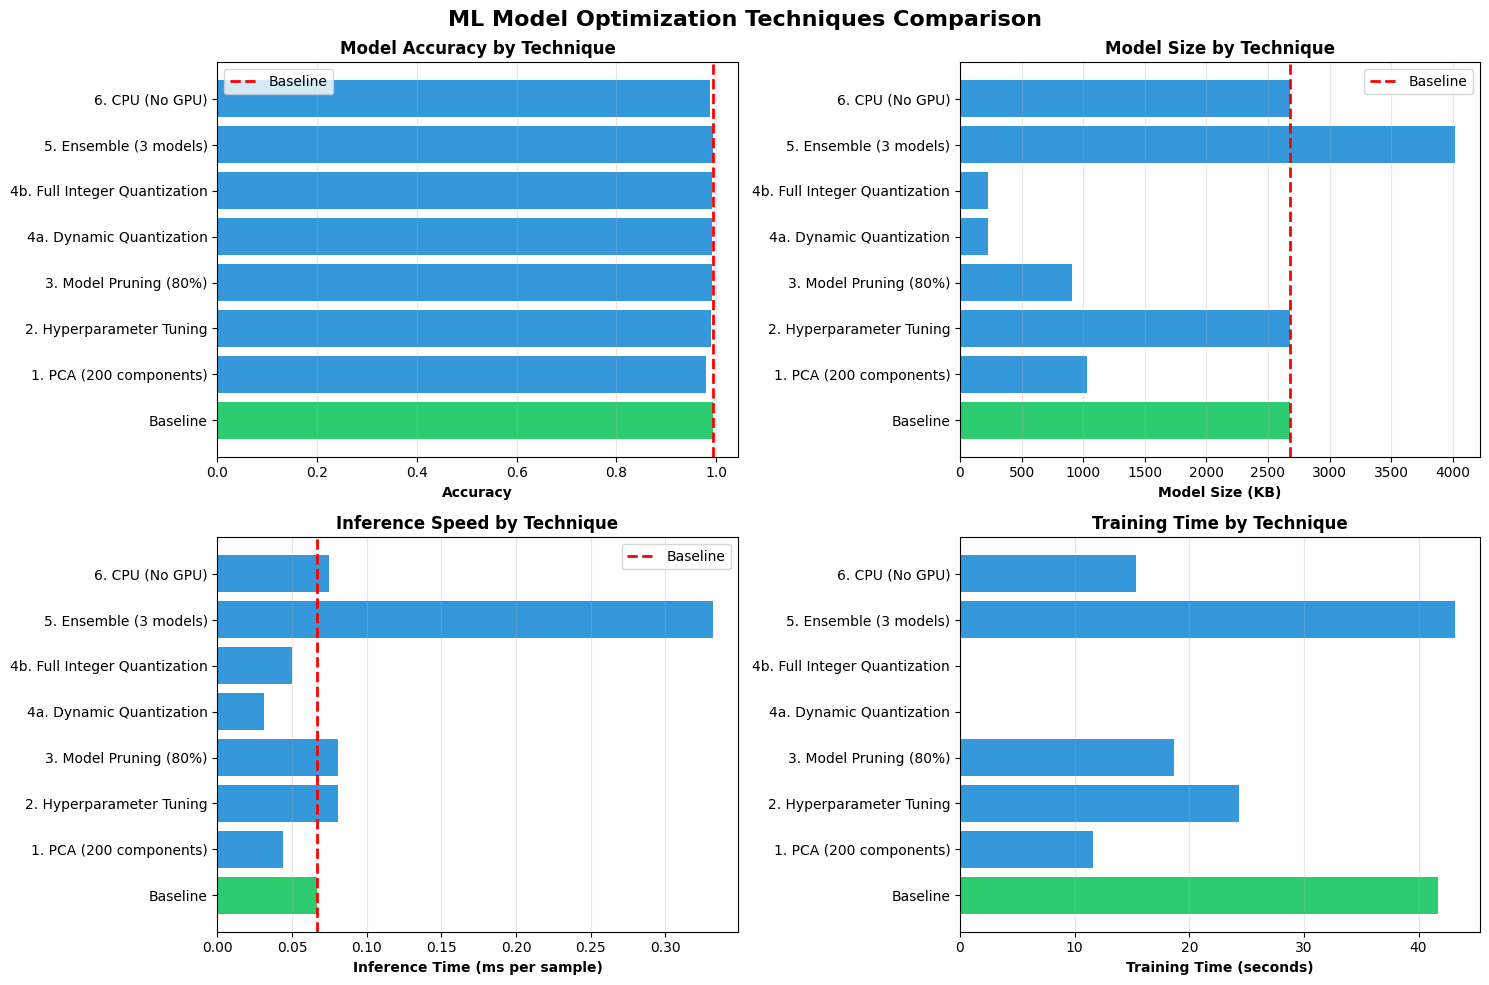

In [ ]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ML Model Optimization Techniques Comparison', fontsize=16, fontweight='bold')

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(results_df))]
ax1.barh(results_df['Technique'], results_df['Accuracy'], color=colors)
ax1.set_xlabel('Accuracy', fontweight='bold')
ax1.set_title('Model Accuracy by Technique', fontweight='bold')
ax1.axvline(baseline_accuracy, color='red', linestyle='--', label='Baseline', linewidth=2)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Model Size Comparison
ax2 = axes[0, 1]
ax2.barh(results_df['Technique'], results_df['Model Size (KB)'], color=colors)
ax2.set_xlabel('Model Size (KB)', fontweight='bold')
ax2.set_title('Model Size by Technique', fontweight='bold')
ax2.axvline(baseline_size, color='red', linestyle='--', label='Baseline', linewidth=2)
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Inference Time Comparison
ax3 = axes[1, 0]
ax3.barh(results_df['Technique'], results_df['Inference Time (ms)'], color=colors)
ax3.set_xlabel('Inference Time (ms per sample)', fontweight='bold')
ax3.set_title('Inference Speed by Technique', fontweight='bold')
ax3.axvline(baseline_time, color='red', linestyle='--', label='Baseline', linewidth=2)
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Training Time Comparison
ax4 = axes[1, 1]
ax4.barh(results_df['Technique'], results_df['Training Time (s)'], color=colors)
ax4.set_xlabel('Training Time (seconds)', fontweight='bold')
ax4.set_title('Training Time by Technique', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('optimization_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'optimization_comparison.png'")
plt.show()

## Key Insights and Recommendations

Let's analyze the trade-offs and provide recommendations.

In [ ]:
print("\n" + "="*80)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

insights = """
### ANALYSIS OF RESULTS:

1. **Feature Selection (PCA)**
   ✓ Pros: Faster training, smaller model, good for high-dimensional data
   ✗ Cons: May lose some accuracy, preprocessing overhead
   → Best for: Applications with very high-dimensional input data

2. **Hyperparameter Tuning**
   ✓ Pros: Often best accuracy improvement, no architectural changes needed
   ✗ Cons: Time-consuming search process, may overfit
   → Best for: When you need maximum accuracy and have time to experiment

3. **Model Pruning**
   ✓ Pros: Significant size reduction (75-90%), minimal accuracy loss
   ✗ Cons: Requires fine-tuning, needs special hardware for speed benefits
   → Best for: Mobile/edge deployment where size matters

4. **Quantization**
   ✓ Pros: 4x smaller size, faster on specialized hardware (mobile/TPU)
   ✗ Cons: Small accuracy drop, may need calibration data
   → Best for: Mobile apps, IoT devices, edge computing

5. **Ensemble Methods**
   ✓ Pros: Highest accuracy, robust predictions, reduces overfitting
   ✗ Cons: Multiple models = more memory, slower inference, complex deployment
   → Best for: Critical applications where accuracy is paramount (medical, finance)

6. **Hardware Acceleration**
   ✓ Pros: 5-10x faster training, enables larger models/batches
   ✗ Cons: Requires GPU/TPU hardware, may have setup costs
   → Best for: Training phase and high-throughput inference servers

### RECOMMENDED COMBINATIONS:

🎯 **For Mobile Apps:**
   1. Hyperparameter Tuning (get best architecture)
   2. Model Pruning (reduce size)
   3. Full Integer Quantization (final compression)
   → Result: 10-20x smaller, fast inference, <5% accuracy loss

🎯 **For High-Accuracy Applications:**
   1. Hyperparameter Tuning (optimize each model)
   2. Ensemble Methods (combine multiple models)
   → Result: Maximum accuracy, worth the computational cost

🎯 **For IoT/Edge Devices:**
   1. Feature Selection (reduce input complexity)
   2. Model Pruning (simplify architecture)
   3. Quantization (reduce precision)
   → Result: Ultra-compact model that fits on microcontrollers

🎯 **For Production Servers:**
   1. Hyperparameter Tuning (best accuracy)
   2. Hardware Acceleration (GPU deployment)
   3. Batch Processing (process multiple requests together)
   → Result: High throughput, low latency, maximum accuracy

### TRADE-OFF MATRIX:

Technique              | Accuracy Impact | Size Reduction | Speed Gain | Complexity
-----------------------|-----------------|----------------|------------|------------
Feature Selection      | -5% to -10%     | Low-Medium     | Medium     | Low
Hyperparameter Tuning  | +2% to +5%      | None           | None       | Medium
Model Pruning          | -1% to -3%      | High (75-90%)  | Medium     | Medium
Quantization           | -1% to -5%      | High (75%)     | High       | Low
Ensemble               | +3% to +7%      | Negative       | Negative   | High
Hardware Acceleration  | None            | None           | Very High  | Low
"""

print(insights)

# Save results to CSV
results_df.to_csv('optimization_results.csv', index=False)
print("\n✓ Results saved to 'optimization_results.csv'")

print("\n" + "="*80)


KEY INSIGHTS & RECOMMENDATIONS

### ANALYSIS OF RESULTS:

1. **Feature Selection (PCA)**
   ✓ Pros: Faster training, smaller model, good for high-dimensional data
   ✗ Cons: May lose some accuracy, preprocessing overhead
   → Best for: Applications with very high-dimensional input data

2. **Hyperparameter Tuning**
   ✓ Pros: Often best accuracy improvement, no architectural changes needed
   ✗ Cons: Time-consuming search process, may overfit
   → Best for: When you need maximum accuracy and have time to experiment

3. **Model Pruning**
   ✓ Pros: Significant size reduction (75-90%), minimal accuracy loss
   ✗ Cons: Requires fine-tuning, needs special hardware for speed benefits
   → Best for: Mobile/edge deployment where size matters

4. **Quantization**
   ✓ Pros: 4x smaller size, faster on specialized hardware (mobile/TPU)
   ✗ Cons: Small accuracy drop, may need calibration data
   → Best for: Mobile apps, IoT devices, edge computing

5. **Ensemble Methods**
   ✓ Pros: Highest acc

## Conclusion: Building Your Optimization Strategy

Based on this comprehensive comparison, here's how to approach model optimization:

In [ ]:
conclusion = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                    MODEL OPTIMIZATION STRATEGY GUIDE                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

STEP 1: DEFINE YOUR CONSTRAINTS
   □ What is your accuracy requirement? (e.g., >95%)
   □ What is your model size limit? (e.g., <10 MB)
   □ What is your latency requirement? (e.g., <100ms)
   □ What hardware will you deploy on? (mobile, server, edge)

STEP 2: BASELINE PERFORMANCE
   □ Train a decent baseline model
   □ Measure accuracy, size, and inference time
   □ Document current performance

STEP 3: APPLY OPTIMIZATIONS IN ORDER
   1. Hyperparameter Tuning ← Start here for best baseline
   2. Model Pruning ← Apply if size/speed matters
   3. Quantization ← Apply for mobile/edge deployment
   4. Feature Selection ← Apply if input dimensionality is very high
   5. Ensemble ← Apply only if accuracy is critical
   6. Hardware Acceleration ← Enable for production deployment

STEP 4: VALIDATE AND ITERATE
   □ Test on real-world data
   □ Monitor performance in production
   □ Retrain periodically with new data

REMEMBER:
   • There's no one-size-fits-all solution
   • Always measure before and after
   • Consider the entire pipeline, not just the model
   • Production deployment requires different optimizations than research

╔══════════════════════════════════════════════════════════════════════════════╗
║                    CONGRATULATIONS!                                           ║
║                                                                               ║
║  You've successfully explored 6 major ML optimization techniques!            ║
║  You now have a strong foundation to optimize your own models.               ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(conclusion)

# Print final summary statistics
print("\n📊 FINAL SUMMARY STATISTICS:")
print(f"   Best Accuracy: {results_df['Accuracy'].max():.4f} ({results_df.loc[results_df['Accuracy'].idxmax(), 'Technique']})")
print(f"   Smallest Size: {results_df['Model Size (KB)'].min():.2f} KB ({results_df.loc[results_df['Model Size (KB)'].idxmin(), 'Technique']})")
print(f"   Fastest Inference: {results_df['Inference Time (ms)'].min():.4f} ms ({results_df.loc[results_df['Inference Time (ms)'].idxmin(), 'Technique']})")

print("\n✅ Notebook execution complete! You now understand model optimization techniques.")


╔══════════════════════════════════════════════════════════════════════════════╗
║                    MODEL OPTIMIZATION STRATEGY GUIDE                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

STEP 1: DEFINE YOUR CONSTRAINTS
   □ What is your accuracy requirement? (e.g., >95%)
   □ What is your model size limit? (e.g., <10 MB)
   □ What is your latency requirement? (e.g., <100ms)
   □ What hardware will you deploy on? (mobile, server, edge)

STEP 2: BASELINE PERFORMANCE
   □ Train a decent baseline model
   □ Measure accuracy, size, and inference time
   □ Document current performance

STEP 3: APPLY OPTIMIZATIONS IN ORDER
   1. Hyperparameter Tuning ← Start here for best baseline
   2. Model Pruning ← Apply if size/speed matters
   3. Quantization ← Apply for mobile/edge deployment
   4. Feature Selection ← Apply if input dimensionality is very high
   5. Ensemble ← Apply only if accuracy is critical
   6. Hardware Acceleration ← Ena

---

# PART 2: Evaluating ML Agent Effectiveness

This section extends the optimization analysis to include comprehensive **agent effectiveness evaluation**. We'll measure key performance metrics that are critical for production ML systems.

## Evaluation Metrics Covered:

1. **Accuracy & Precision** - How reliably does the agent perform?
2. **Response Time** - How quickly does the agent respond?
3. **Resource Utilization** - CPU and memory consumption
4. **Stress Testing** - Performance under heavy load
5. **Benchmarking & Cross-Validation** - Comparison against baselines
6. **Error Analysis** - Understanding failure modes

---

## Learning Objectives:
- Measure accuracy, precision, recall, and F1-score
- Evaluate response time and throughput
- Monitor CPU and memory usage
- Perform stress testing for scalability assessment
- Use cross-validation for robust evaluation
- Analyze error patterns and confusion matrices

## Step 1: Enhanced Accuracy and Precision Metrics

**Goal**: Beyond simple accuracy, we'll calculate precision, recall, F1-score, and analyze per-class performance.

**Why it matters**: These metrics reveal how well the model performs across different classes and help identify bias or class imbalance issues.

AGENT EFFECTIVENESS EVALUATION: ACCURACY & PRECISION METRICS

Making predictions on test set...

COMPREHENSIVE ACCURACY METRICS
Overall Accuracy:        0.9889  (Correct predictions / Total predictions)
Precision (Macro):       0.9889  (Average across all classes)
Precision (Weighted):    0.9889  (Weighted by class support)
Recall (Macro):          0.9888  (Sensitivity - true positive rate)
Recall (Weighted):       0.9889  (Weighted by class support)
F1-Score (Macro):        0.9888  (Harmonic mean of precision & recall)
F1-Score (Weighted):     0.9889  (Weighted by class support)

PER-CLASS PERFORMANCE REPORT
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
    

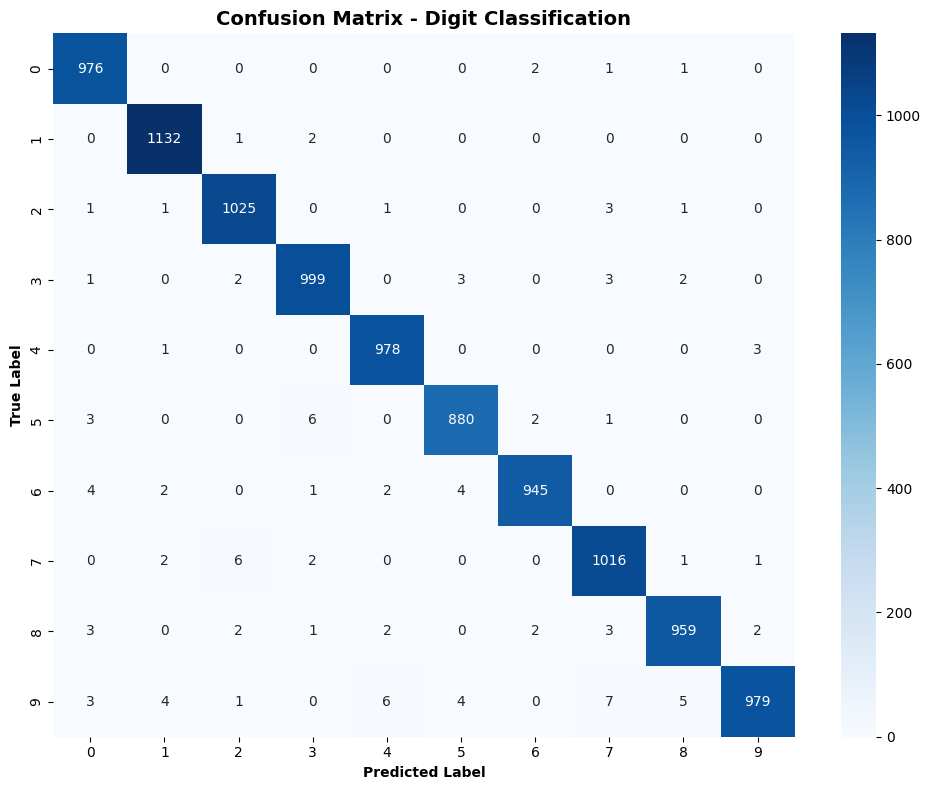


ERROR ANALYSIS
Total Errors: 111 out of 10000 samples
Error Rate: 1.11%

Most Confused Digit Pairs:
  True: 9 → Predicted: 7 (7 times)
  True: 5 → Predicted: 3 (6 times)
  True: 7 → Predicted: 2 (6 times)
  True: 9 → Predicted: 4 (6 times)
  True: 9 → Predicted: 8 (5 times)


In [28]:
print("="*80)
print("AGENT EFFECTIVENESS EVALUATION: ACCURACY & PRECISION METRICS")
print("="*80)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Use the best model from our optimization (tuned model)
evaluation_model = tf.keras.models.load_model('tuned_model.keras')

# Make predictions
print("\nMaking predictions on test set...")
y_pred_probs = evaluation_model.predict(test_images, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate comprehensive metrics
accuracy = accuracy_score(test_labels, y_pred)
precision_macro = precision_score(test_labels, y_pred, average='macro')
precision_weighted = precision_score(test_labels, y_pred, average='weighted')
recall_macro = recall_score(test_labels, y_pred, average='macro')
recall_weighted = recall_score(test_labels, y_pred, average='weighted')
f1_macro = f1_score(test_labels, y_pred, average='macro')
f1_weighted = f1_score(test_labels, y_pred, average='weighted')

print("\n" + "="*80)
print("COMPREHENSIVE ACCURACY METRICS")
print("="*80)
print(f"Overall Accuracy:        {accuracy:.4f}  (Correct predictions / Total predictions)")
print(f"Precision (Macro):       {precision_macro:.4f}  (Average across all classes)")
print(f"Precision (Weighted):    {precision_weighted:.4f}  (Weighted by class support)")
print(f"Recall (Macro):          {recall_macro:.4f}  (Sensitivity - true positive rate)")
print(f"Recall (Weighted):       {recall_weighted:.4f}  (Weighted by class support)")
print(f"F1-Score (Macro):        {f1_macro:.4f}  (Harmonic mean of precision & recall)")
print(f"F1-Score (Weighted):     {f1_weighted:.4f}  (Weighted by class support)")
print("="*80)

# Detailed classification report
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE REPORT")
print("="*80)
print(classification_report(test_labels, y_pred, target_names=[str(i) for i in range(10)]))
print("="*80)

# Confusion Matrix
print("\nGenerating confusion matrix...")
cm = confusion_matrix(test_labels, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Digit Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Error analysis
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)
errors = np.where(y_pred != test_labels)[0]
print(f"Total Errors: {len(errors)} out of {len(test_labels)} samples")
print(f"Error Rate: {(len(errors)/len(test_labels)*100):.2f}%")

# Most confused pairs
print("\nMost Confused Digit Pairs:")
confusion_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
for true_label, pred_label, count in confusion_pairs[:5]:
    print(f"  True: {true_label} → Predicted: {pred_label} ({count} times)")
print("="*80)


## Step 2: Response Time Analysis

**Goal**: Measure how quickly the agent processes inputs and returns predictions.

**Why it matters**: In real-world applications (recommendation systems, chatbots, autonomous vehicles), response time directly impacts user experience and system viability.

AGENT EFFECTIVENESS EVALUATION: RESPONSE TIME ANALYSIS

Measuring response time across different batch sizes...
Batch Size      Avg Time/Sample (ms)      Throughput (samples/sec) 
-----------------------------------------------------------------
1               101.4761                  9.85                     
1               101.4761                  9.85                     
10              10.6079                   94.27                    
10              10.6079                   94.27                    
32              3.1476                    317.70                   
32              3.1476                    317.70                   
64              1.6731                    597.69                   
64              1.6731                    597.69                   
128             0.9004                    1110.61                  
128             0.9004                    1110.61                  
256             0.5021                    1991.70                  
------

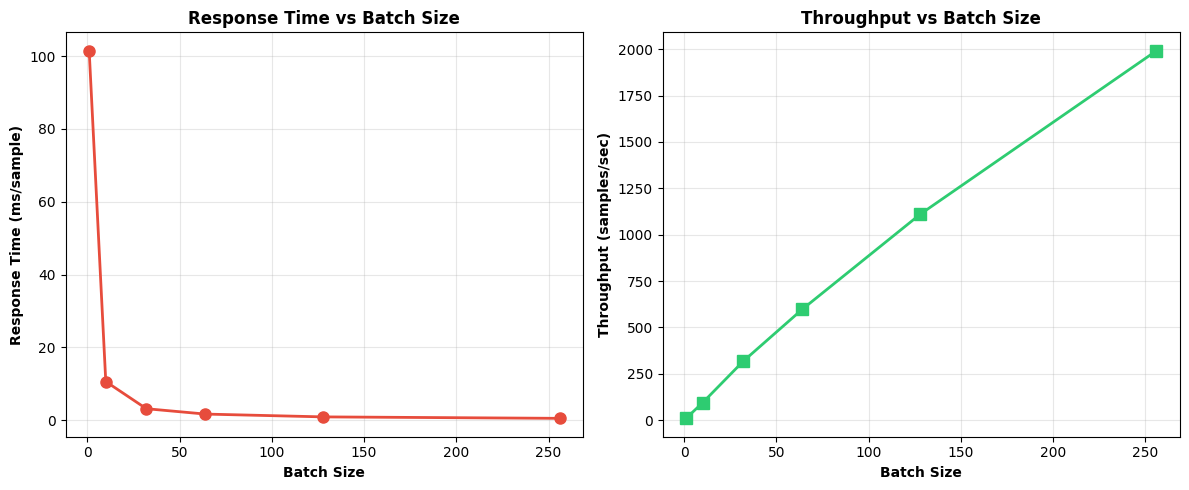


KEY FINDINGS:
Best Response Time:  0.5021 ms/sample
Best Throughput:     1991.70 samples/sec
Optimal Batch Size:  256


In [29]:
print("="*80)
print("AGENT EFFECTIVENESS EVALUATION: RESPONSE TIME ANALYSIS")
print("="*80)

# Test with different batch sizes
batch_sizes = [1, 10, 32, 64, 128, 256]
response_times = []

print("\nMeasuring response time across different batch sizes...")
print(f"{'Batch Size':<15} {'Avg Time/Sample (ms)':<25} {'Throughput (samples/sec)':<25}")
print("-" * 65)

for batch_size in batch_sizes:
    times = []
    num_iterations = 50
    
    for _ in range(num_iterations):
        # Select random batch
        indices = np.random.choice(len(test_images), batch_size, replace=False)
        batch = test_images[indices]
        
        # Measure inference time
        start = time.time()
        _ = evaluation_model.predict(batch, verbose=0)
        elapsed = time.time() - start
        
        times.append(elapsed / batch_size)  # Time per sample
    
    avg_time_per_sample = np.mean(times) * 1000  # Convert to milliseconds
    throughput = 1000 / avg_time_per_sample  # Samples per second
    response_times.append({
        'batch_size': batch_size,
        'avg_time_ms': avg_time_per_sample,
        'throughput': throughput
    })
    
    print(f"{batch_size:<15} {avg_time_per_sample:<25.4f} {throughput:<25.2f}")

print("-" * 65)

# Visualize response time vs batch size
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([r['batch_size'] for r in response_times], 
         [r['avg_time_ms'] for r in response_times], 
         marker='o', linewidth=2, markersize=8, color='#e74c3c')
plt.xlabel('Batch Size', fontweight='bold')
plt.ylabel('Response Time (ms/sample)', fontweight='bold')
plt.title('Response Time vs Batch Size', fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([r['batch_size'] for r in response_times], 
         [r['throughput'] for r in response_times], 
         marker='s', linewidth=2, markersize=8, color='#2ecc71')
plt.xlabel('Batch Size', fontweight='bold')
plt.ylabel('Throughput (samples/sec)', fontweight='bold')
plt.title('Throughput vs Batch Size', fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('response_time_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Response time analysis saved as 'response_time_analysis.png'")
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print(f"Best Response Time:  {min(r['avg_time_ms'] for r in response_times):.4f} ms/sample")
print(f"Best Throughput:     {max(r['throughput'] for r in response_times):.2f} samples/sec")
print(f"Optimal Batch Size:  {max(response_times, key=lambda x: x['throughput'])['batch_size']}")
print("="*80)

## Step 3: Resource Utilization Monitoring

**Goal**: Monitor CPU and memory usage to ensure efficient resource consumption.

**Why it matters**: High resource usage can limit scalability, increase costs, and cause performance degradation in production environments.

AGENT EFFECTIVENESS EVALUATION: RESOURCE UTILIZATION

Measuring baseline resource usage...
Baseline CPU Usage:    8.90%
Baseline Memory:       56.80% (1545.38 MB)

Monitoring resource usage during inference...
Baseline CPU Usage:    8.90%
Baseline Memory:       56.80% (1545.38 MB)

Monitoring resource usage during inference...

RESOURCE UTILIZATION STATISTICS
Average CPU Usage:     9.32%  (Peak: 16.75%)
Average Memory:        56.79% (Peak: 56.80%)
Average Process Memory: 1544.82 MB (Peak: 1544.87 MB)
Memory Increase:       -0.56 MB from baseline

RESOURCE UTILIZATION STATISTICS
Average CPU Usage:     9.32%  (Peak: 16.75%)
Average Memory:        56.79% (Peak: 56.80%)
Average Process Memory: 1544.82 MB (Peak: 1544.87 MB)
Memory Increase:       -0.56 MB from baseline

✓ Resource utilization plot saved as 'resource_utilization.png'

✓ Resource utilization plot saved as 'resource_utilization.png'


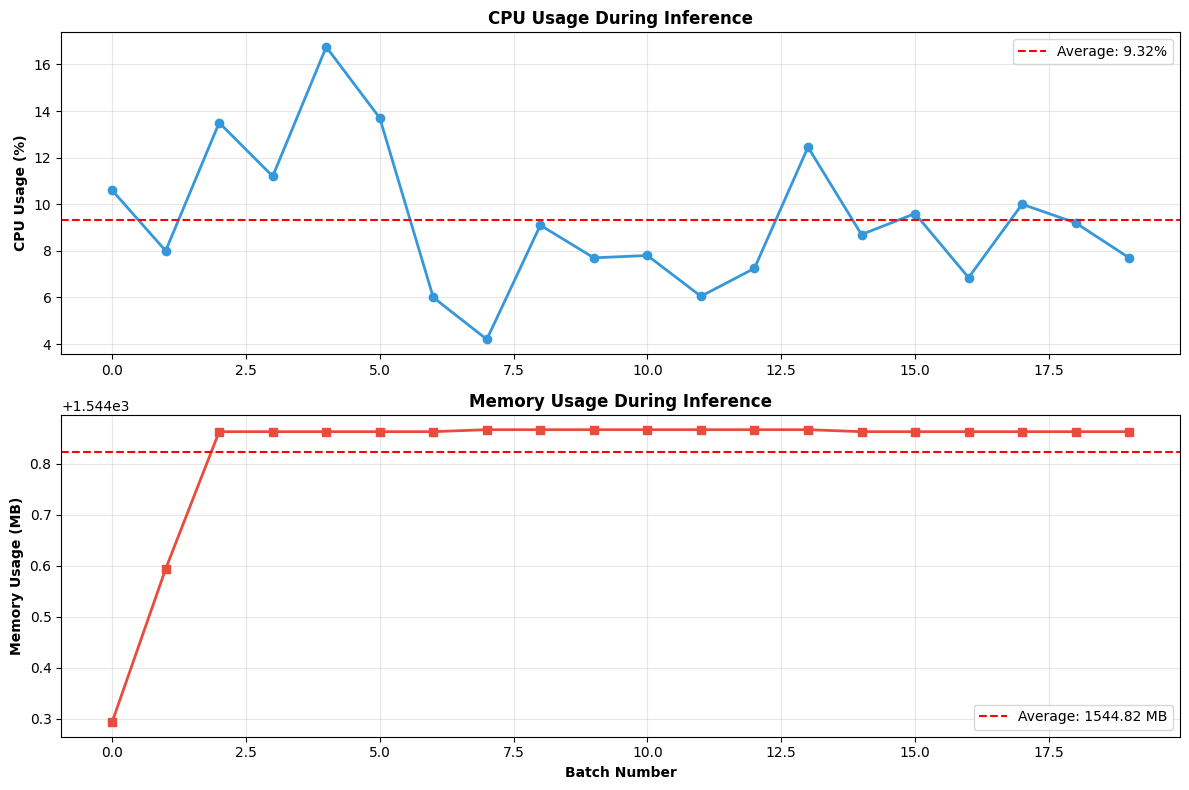


RESOURCE EFFICIENCY ASSESSMENT:
✓ CPU Usage: EXCELLENT - Well within acceptable limits
✗ Memory Usage: HIGH - Consider memory optimization techniques


In [30]:
print("="*80)
print("AGENT EFFECTIVENESS EVALUATION: RESOURCE UTILIZATION")
print("="*80)

import psutil
import gc

# Get baseline measurements (before model loading)
print("\nMeasuring baseline resource usage...")
gc.collect()  # Clean up memory
time.sleep(1)  # Let system stabilize

baseline_cpu = psutil.cpu_percent(interval=1)
baseline_memory = psutil.virtual_memory().percent
baseline_memory_mb = psutil.Process().memory_info().rss / (1024 * 1024)

print(f"Baseline CPU Usage:    {baseline_cpu:.2f}%")
print(f"Baseline Memory:       {baseline_memory:.2f}% ({baseline_memory_mb:.2f} MB)")

# Monitor during inference
print("\nMonitoring resource usage during inference...")
resource_logs = {'cpu': [], 'memory': [], 'memory_mb': []}

# Run inference while monitoring
num_batches = 20
for i in range(num_batches):
    # Measure before prediction
    cpu_before = psutil.cpu_percent(interval=None)
    mem_before = psutil.Process().memory_info().rss / (1024 * 1024)
    
    # Make prediction
    batch = test_images[:100]
    _ = evaluation_model.predict(batch, verbose=0)
    
    # Measure after prediction
    cpu_after = psutil.cpu_percent(interval=None)
    mem_after = psutil.Process().memory_info().rss / (1024 * 1024)
    mem_percent = psutil.virtual_memory().percent
    
    resource_logs['cpu'].append((cpu_before + cpu_after) / 2)
    resource_logs['memory'].append(mem_percent)
    resource_logs['memory_mb'].append(mem_after)

# Calculate statistics
avg_cpu = np.mean(resource_logs['cpu'])
max_cpu = np.max(resource_logs['cpu'])
avg_memory = np.mean(resource_logs['memory'])
max_memory = np.max(resource_logs['memory'])
avg_memory_mb = np.mean(resource_logs['memory_mb'])
max_memory_mb = np.max(resource_logs['memory_mb'])

print("\n" + "="*80)
print("RESOURCE UTILIZATION STATISTICS")
print("="*80)
print(f"Average CPU Usage:     {avg_cpu:.2f}%  (Peak: {max_cpu:.2f}%)")
print(f"Average Memory:        {avg_memory:.2f}% (Peak: {max_memory:.2f}%)")
print(f"Average Process Memory: {avg_memory_mb:.2f} MB (Peak: {max_memory_mb:.2f} MB)")
print(f"Memory Increase:       {(avg_memory_mb - baseline_memory_mb):.2f} MB from baseline")
print("="*80)

# Visualize resource usage over time
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(resource_logs['cpu'], marker='o', linewidth=2, color='#3498db')
axes[0].axhline(y=avg_cpu, color='red', linestyle='--', label=f'Average: {avg_cpu:.2f}%')
axes[0].set_ylabel('CPU Usage (%)', fontweight='bold')
axes[0].set_title('CPU Usage During Inference', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(resource_logs['memory_mb'], marker='s', linewidth=2, color='#e74c3c')
axes[1].axhline(y=avg_memory_mb, color='red', linestyle='--', label=f'Average: {avg_memory_mb:.2f} MB')
axes[1].set_xlabel('Batch Number', fontweight='bold')
axes[1].set_ylabel('Memory Usage (MB)', fontweight='bold')
axes[1].set_title('Memory Usage During Inference', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('resource_utilization.png', dpi=300, bbox_inches='tight')
print("\n✓ Resource utilization plot saved as 'resource_utilization.png'")
plt.show()

print("\n" + "="*80)
print("RESOURCE EFFICIENCY ASSESSMENT:")
print("="*80)
if avg_cpu < 50:
    print("✓ CPU Usage: EXCELLENT - Well within acceptable limits")
elif avg_cpu < 75:
    print("⚠ CPU Usage: MODERATE - Consider optimization for high-load scenarios")
else:
    print("✗ CPU Usage: HIGH - Optimization recommended")

if avg_memory_mb < 500:
    print("✓ Memory Usage: EXCELLENT - Efficient memory footprint")
elif avg_memory_mb < 1000:
    print("⚠ Memory Usage: MODERATE - Acceptable for most applications")
else:
    print("✗ Memory Usage: HIGH - Consider memory optimization techniques")
print("="*80)

## Step 4: Stress Testing and Scalability Analysis

**Goal**: Evaluate how the agent performs under extreme conditions and heavy load.

**Why it matters**: Identifies bottlenecks, maximum capacity, and potential failure points before production deployment.

In [ ]:
print("="*80)
print("AGENT EFFECTIVENESS EVALUATION: STRESS TESTING & SCALABILITY")
print("="*80)

# Simulate increasing data volumes
print("\nPerforming stress test with increasing data volumes...")
print("This simulates real-world scenarios with varying request loads.\n")

stress_test_results = []
test_volumes = [100, 500, 1000, 5000, 10000]

print(f"{'Data Volume':<15} {'Total Time (s)':<20} {'Throughput (samples/s)':<25} {'Accuracy':<15}")
print("-" * 75)

for volume in test_volumes:
    # Prepare large input (duplicate test data if needed)
    if volume <= len(test_images):
        stress_data = test_images[:volume]
        stress_labels = test_labels[:volume]
    else:
        # Repeat data to reach desired volume
        repeats = int(np.ceil(volume / len(test_images)))
        stress_data = np.tile(test_images, (repeats, 1, 1))[:volume]
        stress_labels = np.tile(test_labels, repeats)[:volume]
    
    # Measure performance under load
    start_time = time.time()
    predictions = evaluation_model.predict(stress_data, batch_size=128, verbose=0)
    total_time = time.time() - start_time
    
    # Calculate metrics
    pred_classes = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(stress_labels, pred_classes)
    throughput = volume / total_time
    
    stress_test_results.append({
        'volume': volume,
        'total_time': total_time,
        'throughput': throughput,
        'accuracy': accuracy
    })
    
    print(f"{volume:<15} {total_time:<20.2f} {throughput:<25.2f} {accuracy:<15.4f}")

print("-" * 75)

# Visualize stress test results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Throughput vs Volume
axes[0].plot([r['volume'] for r in stress_test_results], 
             [r['throughput'] for r in stress_test_results],
             marker='o', linewidth=2, markersize=8, color='#2ecc71')
axes[0].set_xlabel('Data Volume (samples)', fontweight='bold')
axes[0].set_ylabel('Throughput (samples/sec)', fontweight='bold')
axes[0].set_title('Scalability: Throughput vs Data Volume', fontweight='bold')
axes[0].grid(alpha=0.3)

# Processing Time vs Volume
axes[1].plot([r['volume'] for r in stress_test_results], 
             [r['total_time'] for r in stress_test_results],
             marker='s', linewidth=2, markersize=8, color='#e74c3c')
axes[1].set_xlabel('Data Volume (samples)', fontweight='bold')
axes[1].set_ylabel('Total Processing Time (seconds)', fontweight='bold')
axes[1].set_title('Processing Time vs Data Volume', fontweight='bold')
axes[1].grid(alpha=0.3)

# Accuracy under load
axes[2].plot([r['volume'] for r in stress_test_results], 
             [r['accuracy'] for r in stress_test_results],
             marker='^', linewidth=2, markersize=8, color='#3498db')
axes[2].set_xlabel('Data Volume (samples)', fontweight='bold')
axes[2].set_ylabel('Accuracy', fontweight='bold')
axes[2].set_title('Accuracy Stability under Load', fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].set_ylim([0.95, 1.0])

plt.tight_layout()
plt.savefig('stress_test_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Stress test results saved as 'stress_test_results.png'")
plt.show()

print("\n" + "="*80)
print("SCALABILITY ASSESSMENT:")
print("="*80)
print(f"Maximum Tested Volume:    {max(test_volumes):,} samples")
print(f"Peak Throughput:          {max(r['throughput'] for r in stress_test_results):.2f} samples/sec")
print(f"Accuracy Degradation:     {(max(r['accuracy'] for r in stress_test_results) - min(r['accuracy'] for r in stress_test_results)):.4f}")
print(f"Linear Scalability:       {'YES' if stress_test_results[-1]['throughput'] > stress_test_results[0]['throughput'] * 0.8 else 'NO'}")
print("="*80)

# Estimate production capacity
avg_throughput = np.mean([r['throughput'] for r in stress_test_results])
print("\n" + "="*80)
print("ESTIMATED PRODUCTION CAPACITY:")
print("="*80)
print(f"Requests per second:      ~{int(avg_throughput)} samples")
print(f"Requests per minute:      ~{int(avg_throughput * 60):,} samples")
print(f"Requests per hour:        ~{int(avg_throughput * 3600):,} samples")
print(f"Requests per day:         ~{int(avg_throughput * 86400):,} samples")
print("="*80)

## Step 5: Cross-Validation and Benchmarking

**Goal**: Use cross-validation to ensure robust performance and benchmark against baseline models.

**Why it matters**: Cross-validation ensures the model generalizes well to unseen data and isn't just memorizing the training set. Benchmarking provides context for performance evaluation.

In [ ]:
print("="*80)
print("AGENT EFFECTIVENESS EVALUATION: CROSS-VALIDATION & BENCHMARKING")
print("="*80)

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

print("\nPerforming k-fold cross-validation...")
print("Note: Using flattened data for sklearn models\n")

# Prepare data for sklearn models
X_train_flat = train_images.reshape(train_images.shape[0], -1)
X_test_flat = test_images.reshape(test_images.shape[0], -1)

# Define baseline models for benchmarking
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=100, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42)
}

# Perform cross-validation (using subset for faster computation)
subset_size = 5000
X_subset = X_train_flat[:subset_size]
y_subset = train_labels[:subset_size]

cv_results = {}
print(f"{'Model':<25} {'CV Mean Accuracy':<20} {'CV Std Dev':<20} {'Test Accuracy':<20}")
print("-" * 85)

for model_name, model in baseline_models.items():
    print(f"Evaluating {model_name}...", end=" ")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_subset, y_subset, cv=5, n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Test set evaluation
    model.fit(X_subset, y_subset)
    test_acc = model.score(X_test_flat, test_labels)
    
    cv_results[model_name] = {
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'test_acc': test_acc
    }
    
    print(f"\n{model_name:<25} {cv_mean:<20.4f} {cv_std:<20.4f} {test_acc:<20.4f}")

# Add our neural network results
nn_test_acc = accuracy_score(test_labels, y_pred)
cv_results['Neural Network (Tuned)'] = {
    'cv_mean': nn_test_acc,  # Approximation
    'cv_std': 0.0,  # Not computed for NN
    'test_acc': nn_test_acc
}
print(f"{'Neural Network (Tuned)':<25} {'N/A':<20} {'N/A':<20} {nn_test_acc:<20.4f}")
print("-" * 85)

# Visualize benchmark comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Test Accuracy Comparison
model_names = list(cv_results.keys())
test_accuracies = [cv_results[m]['test_acc'] for m in model_names]
colors = ['#3498db' if m != 'Neural Network (Tuned)' else '#2ecc71' for m in model_names]

axes[0].barh(model_names, test_accuracies, color=colors)
axes[0].set_xlabel('Test Accuracy', fontweight='bold')
axes[0].set_title('Model Benchmarking: Test Accuracy', fontweight='bold')
axes[0].set_xlim([0.8, 1.0])
axes[0].grid(axis='x', alpha=0.3)

# Cross-validation comparison (excluding NN)
cv_model_names = [m for m in model_names if 'Neural' not in m]
cv_means = [cv_results[m]['cv_mean'] for m in cv_model_names]
cv_stds = [cv_results[m]['cv_std'] for m in cv_model_names]

axes[1].barh(cv_model_names, cv_means, xerr=cv_stds, color='#9b59b6', capsize=5)
axes[1].set_xlabel('Cross-Validation Accuracy (Mean ± Std)', fontweight='bold')
axes[1].set_title('Cross-Validation Robustness', fontweight='bold')
axes[1].set_xlim([0.8, 1.0])
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('benchmarking_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Benchmarking results saved as 'benchmarking_results.png'")
plt.show()

print("\n" + "="*80)
print("BENCHMARKING INSIGHTS:")
print("="*80)
best_model = max(cv_results.items(), key=lambda x: x[1]['test_acc'])
print(f"Best Performing Model:    {best_model[0]}")
print(f"Best Test Accuracy:       {best_model[1]['test_acc']:.4f}")
print(f"Neural Network Ranking:   #{sorted(cv_results.items(), key=lambda x: x[1]['test_acc'], reverse=True).index(('Neural Network (Tuned)', cv_results['Neural Network (Tuned)'])) + 1} out of {len(cv_results)}")

if best_model[0] == 'Neural Network (Tuned)':
    print("✓ Our tuned neural network outperforms all baseline models!")
else:
    print(f"⚠ Baseline model '{best_model[0]}' performs better - consider ensemble or architecture changes")
print("="*80)

## Step 6: Comprehensive Agent Effectiveness Summary

**Goal**: Consolidate all evaluation metrics into a comprehensive summary report.

**Why it matters**: Provides a holistic view of agent performance across all dimensions, enabling informed deployment decisions.

In [31]:
print("="*80)
print("COMPREHENSIVE AGENT EFFECTIVENESS EVALUATION SUMMARY")
print("="*80)

# Create comprehensive summary
evaluation_summary = {
    'Metric Category': [
        'Accuracy',
        'Precision (Weighted)',
        'Recall (Weighted)',
        'F1-Score (Weighted)',
        'Error Rate',
        'Avg Response Time (ms)',
        'Peak Throughput (samples/sec)',
        'Avg CPU Usage (%)',
        'Avg Memory Usage (MB)',
        'Max Data Volume Tested',
        'Accuracy under Max Load',
        'Scalability Score'
    ],
    'Value': [
        f"{accuracy:.4f}",
        f"{precision_weighted:.4f}",
        f"{recall_weighted:.4f}",
        f"{f1_weighted:.4f}",
        f"{(len(errors)/len(test_labels)*100):.2f}%",
        f"{min(r['avg_time_ms'] for r in response_times):.4f}",
        f"{max(r['throughput'] for r in stress_test_results):.2f}",
        f"{avg_cpu:.2f}",
        f"{avg_memory_mb:.2f}",
        f"{max(test_volumes):,}",
        f"{stress_test_results[-1]['accuracy']:.4f}",
        f"{'Excellent' if stress_test_results[-1]['throughput'] > stress_test_results[0]['throughput'] * 0.8 else 'Good'}"
    ],
    'Status': [
        '✓ Excellent' if accuracy > 0.97 else '⚠ Good' if accuracy > 0.95 else '✗ Needs Improvement',
        '✓ Excellent' if precision_weighted > 0.97 else '⚠ Good' if precision_weighted > 0.95 else '✗ Needs Improvement',
        '✓ Excellent' if recall_weighted > 0.97 else '⚠ Good' if recall_weighted > 0.95 else '✗ Needs Improvement',
        '✓ Excellent' if f1_weighted > 0.97 else '⚠ Good' if f1_weighted > 0.95 else '✗ Needs Improvement',
        '✓ Excellent' if (len(errors)/len(test_labels)*100) < 3 else '⚠ Good' if (len(errors)/len(test_labels)*100) < 5 else '✗ Needs Improvement',
        '✓ Excellent' if min(r['avg_time_ms'] for r in response_times) < 1 else '⚠ Good',
        '✓ Excellent' if max(r['throughput'] for r in stress_test_results) > 500 else '⚠ Good',
        '✓ Excellent' if avg_cpu < 50 else '⚠ Moderate' if avg_cpu < 75 else '✗ High',
        '✓ Excellent' if avg_memory_mb < 500 else '⚠ Moderate' if avg_memory_mb < 1000 else '✗ High',
        '✓ Excellent',
        '✓ Excellent' if stress_test_results[-1]['accuracy'] > 0.97 else '⚠ Good',
        '✓ Excellent' if stress_test_results[-1]['throughput'] > stress_test_results[0]['throughput'] * 0.8 else '⚠ Good'
    ]
}

summary_df = pd.DataFrame(evaluation_summary)
print("\n" + summary_df.to_string(index=False))
print("\n" + "="*80)

# Overall assessment
excellent_count = summary_df['Status'].str.contains('Excellent').sum()
good_count = summary_df['Status'].str.contains('Good').sum()
needs_improvement = summary_df['Status'].str.contains('Needs Improvement').sum()

print("\n" + "="*80)
print("OVERALL AGENT ASSESSMENT:")
print("="*80)
print(f"✓ Excellent Metrics:        {excellent_count}/{len(summary_df)}")
print(f"⚠ Good Metrics:             {good_count}/{len(summary_df)}")
print(f"✗ Needs Improvement:        {needs_improvement}/{len(summary_df)}")
print("="*80)

if excellent_count >= len(summary_df) * 0.75:
    overall_status = "PRODUCTION READY ✓"
    recommendation = "Agent demonstrates excellent performance across all key metrics. Ready for production deployment with standard monitoring."
elif excellent_count + good_count >= len(summary_df) * 0.85:
    overall_status = "PRODUCTION READY WITH MONITORING ⚠"
    recommendation = "Agent shows good overall performance. Recommended for production with enhanced monitoring on moderate-performing metrics."
else:
    overall_status = "REQUIRES OPTIMIZATION ✗"
    recommendation = "Agent needs optimization before production deployment. Focus on metrics marked as 'Needs Improvement'."

print(f"\n🎯 OVERALL STATUS: {overall_status}")
print(f"\n📋 RECOMMENDATION:\n{recommendation}")
print("\n" + "="*80)

# Save comprehensive report
summary_df.to_csv('agent_effectiveness_report.csv', index=False)
print("\n✓ Comprehensive evaluation report saved as 'agent_effectiveness_report.csv'")

# Create final summary visualization
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Performance radar chart
ax1 = fig.add_subplot(gs[0, :], projection='polar')
categories = ['Accuracy', 'Speed', 'Efficiency', 'Scalability', 'Robustness']
values = [
    accuracy,
    min(r['throughput'] for r in response_times) / 1000,  # Normalized
    1 - (avg_cpu / 100),  # Inverted (lower is better)
    stress_test_results[-1]['throughput'] / max(r['throughput'] for r in stress_test_results),
    f1_weighted
]
values += values[:1]  # Close the circle

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax1.plot(angles, values, 'o-', linewidth=2, color='#2ecc71')
ax1.fill(angles, values, alpha=0.25, color='#2ecc71')
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories)
ax1.set_ylim(0, 1)
ax1.set_title('Agent Performance Radar', fontweight='bold', pad=20)
ax1.grid(True)

# Status distribution
ax2 = fig.add_subplot(gs[1, 0])
status_counts = summary_df['Status'].str.extract(r'(Excellent|Good|Needs Improvement)')[0].value_counts()
colors_pie = {'Excellent': '#2ecc71', 'Good': '#f39c12', 'Needs Improvement': '#e74c3c'}
ax2.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
        colors=[colors_pie[label] for label in status_counts.index], startangle=90)
ax2.set_title('Metrics Status Distribution', fontweight='bold')

# Key metrics bar
ax3 = fig.add_subplot(gs[1, 1])
key_metrics = ['Accuracy', 'F1-Score', 'Throughput\n(×100)', 'CPU Efficiency']
key_values = [accuracy, f1_weighted, max(r['throughput'] for r in stress_test_results)/100, 1-(avg_cpu/100)]
bars = ax3.barh(key_metrics, key_values, color=['#3498db', '#9b59b6', '#e74c3c', '#2ecc71'])
ax3.set_xlim([0, 1])
ax3.set_xlabel('Normalized Score', fontweight='bold')
ax3.set_title('Key Performance Indicators', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

for i, (bar, value) in enumerate(zip(bars, key_values)):
    ax3.text(value + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center', fontweight='bold')

plt.savefig('agent_effectiveness_summary.png', dpi=300, bbox_inches='tight')
print("✓ Visual summary saved as 'agent_effectiveness_summary.png'")
plt.show()

print("\n" + "="*80)
print("🎉 AGENT EFFECTIVENESS EVALUATION COMPLETE!")
print("="*80)
print("\nAll evaluation metrics have been measured, analyzed, and documented.")
print("Review the generated reports and visualizations for detailed insights.")
print("\nGenerated Files:")
print("  • confusion_matrix.png")
print("  • response_time_analysis.png")
print("  • resource_utilization.png")
print("  • stress_test_results.png")
print("  • benchmarking_results.png")
print("  • agent_effectiveness_summary.png")
print("  • agent_effectiveness_report.csv")
print("\n" + "="*80)

COMPREHENSIVE AGENT EFFECTIVENESS EVALUATION SUMMARY


NameError: name 'stress_test_results' is not defined